In [1]:
import pandas as pd
import numpy as np
from ipywidgets import interact
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
from tqdm.auto import tqdm

In [2]:
transactions = pd.read_csv("../data/dunnhumby_The-Complete-Journey/dunnhumby - The Complete Journey CSV/transaction_data.csv")

## Spending on days of week

We have analyzed how many transactions are made on each day.

Unfortunately, our data didn't have labels specifying which number corresponds to which day of the week, but we tried to make some hypotheses.

In [5]:
transactions["DAY_OF_WEEK"] = (transactions["DAY"] - 6) % 7 + 1

In [6]:
dow = transactions.groupby(["DAY_OF_WEEK"])["BASKET_ID"].nunique()

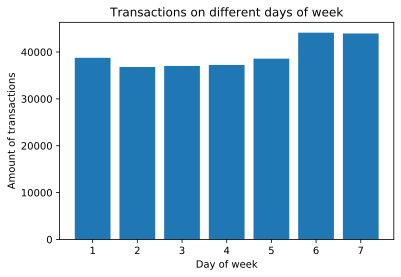

In [8]:
plt.bar(dow.index, dow)
plt.title("Transactions on different days of week")
plt.xlabel("Day of week")
plt.ylabel("Amount of transactions")
plt.show()

As we can see, there are most transactions on days 6 and 7 and least on 2, 3 and 4. 

We hypothesize that 6 and 7 are Saturday and Sunday because it is likely that more transactions would be made during the weekend as most people have time on these days to go shopping. One thing we have considered is that in many countries shops are actually closed on Sundays, so that would result in a big drop of sales on that day, but there is no day that would be a clear outlier of having almost none transactions, so we guess that these shops operate on every day of the week.

The small increase on days 1 and 5 seems in line with this hypothesis, as people are likely going shopping slightly more often on Mondays for example to refill after having guests on the weekend and on Fridays for numerous reasons (to prepare for a weekend trip or a party, or just having finished work).

In [14]:
# compute an approximation of which month we are in (assuming all months are 30 days)
transactions["MONTH"] = (np.floor(transactions["DAY"] / 30) + 1).apply(int)

In [11]:
products = pd.read_csv("../data/dunnhumby_The-Complete-Journey/dunnhumby - The Complete Journey CSV/product.csv")

In [15]:
merged = transactions.merge(products)

In [54]:
demographic = pd.read_csv("../data/dunnhumby_The-Complete-Journey/dunnhumby - The Complete Journey CSV/hh_demographic.csv")

In [55]:
transactions_demographic = merged.merge(demographic)

Also after looking at how many transactions people from each group are making, we can see that while most people's habits don't differ that much with age, there is is a tendency for older people to do shopping on Sundays much less often then younger ones.

The youth actually seems to prefer Sundays as their favorite shopping day, while the seniors are actually prefering Fridays.

In [78]:
data = transactions_demographic[(transactions_demographic.SUB_COMMODITY_DESC != "GASOLINE-REG UNLEADED")]

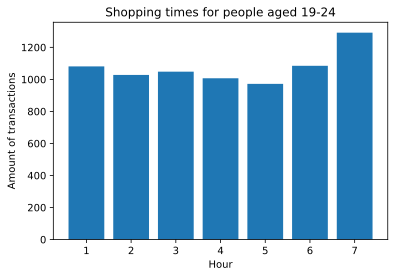

In [79]:
stat = data[data["AGE_DESC"] == "19-24"].groupby("DAY_OF_WEEK")["BASKET_ID"].nunique()
plt.title("Shopping times for people aged 19-24")
plt.xlabel("Hour")
plt.ylabel("Amount of transactions")
plt.bar(stat.index, stat)
plt.show()

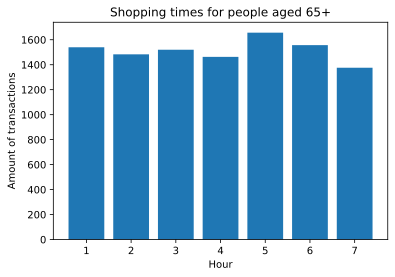

In [80]:
stat = data[data["AGE_DESC"] == "65+"].groupby("DAY_OF_WEEK")["BASKET_ID"].nunique()
plt.title("Shopping times for people aged 65+")
plt.xlabel("Hour")
plt.ylabel("Amount of transactions")
plt.bar(stat.index, stat)
plt.show()

## Sales at different times of day

We now look if there are any rush hours in the shops.

In [17]:
transactions["HOUR"] = np.floor(transactions.TRANS_TIME / 100).apply(int)

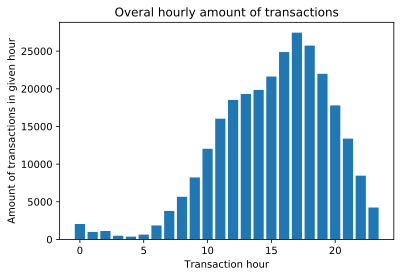

In [37]:
overall = transactions.groupby("HOUR")["BASKET_ID"].nunique()
plt.bar(overall.index, overall)
plt.title("Overal hourly amount of transactions")
plt.xlabel("Transaction hour")
plt.ylabel("Amount of transactions in given hour")
plt.show()

We now compare the amount of transactions on the weekends and the weekdays.

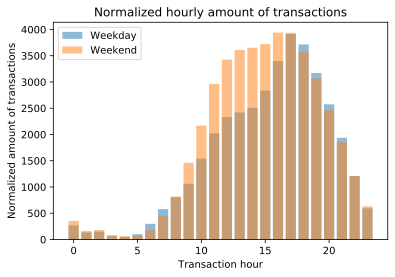

In [40]:
weekday = transactions[transactions["DAY_OF_WEEK"] < 6].groupby("HOUR")["BASKET_ID"].nunique()
plt.bar(weekday.index, weekday / 5, label="Weekday", alpha=0.5)
weekend = transactions[transactions["DAY_OF_WEEK"] >= 6].groupby("HOUR")["BASKET_ID"].nunique()
plt.bar(weekend.index, weekend / 2, label="Weekend", alpha=0.5)
plt.title("Normalized hourly amount of transactions")
plt.xlabel("Transaction hour")
plt.ylabel("Normalized amount of transactions")
plt.legend()
plt.show()

As the weekend lasts only 2 days and there are 5 weekdays, to get a fair comparison, we have divided the transaction amounts on weekends by 2 and by 5 on weekdays. So the bar height represents the average amount of transactions on one day of the respective period.

We can see that on weekdays there are much less sales between 9 and 16. Of course this makes sense as during the week, most people are working during that time. There are more sales in the early morning and late evening likely caused by people doing the shopping before or after work.

In [43]:
transactions_demographic["HOUR"] = np.floor(transactions_demographic.TRANS_TIME / 100).apply(int)

In [51]:
def times_over_category(data, category_column, show_separate=True, sort=True, minimal_threshold=None):
    
    sums = data.groupby([category_column, "HOUR"])["BASKET_ID"].nunique()
    overall = data.groupby(category_column)["BASKET_ID"].nunique()
    if minimal_threshold is not None:
        sums = sums[sums.index.isin(overall[overall > minimal_threshold].index, level=0)]

    values = sums.index.unique(level=0)
    if sort:
        values = sorted(values)
        
    if show_separate:
        for cat in values:
            stat = sums[cat]
            plt.title("Shopping times for category " + cat)
            plt.xlabel("Hour")
            plt.ylabel("Amount of transactions")
            plt.bar(stat.index, stat)
            plt.show()
    
    # for the second step we normalize the sums
    
    sums = sums / overall

    
    plt.figure(figsize=(10,8))
    for cat in values:
        stat = sums[cat]
        plt.plot(stat.index, stat, label=cat)
    plt.xlabel("Hour")
    plt.ylabel("Relative amount of transactions")
    plt.title("Relativized comparison of transaction times of different ages")
    plt.legend()
    plt.show()

We now wanted to see how the usual transaction time varies by demographic.

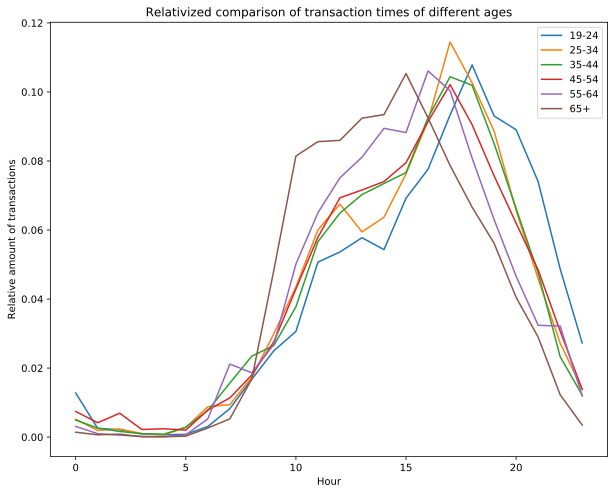

In [52]:
# TODO maybe normalize the gasoline
times_over_category(transactions_demographic[(transactions_demographic.SUB_COMMODITY_DESC != "GASOLINE-REG UNLEADED")], "AGE_DESC", show_separate=False)

Here we can see that older people tend to do the shopping in the late morning and early afternoon - starting at 9, and with a peak activity at 15.

Adults tend to do most of their shopping later - with most of them shopping around 17-18.

The youngest age group (19-24) tend to do the shopping in the evening - peaking around 18 and being relatively more active in the night.


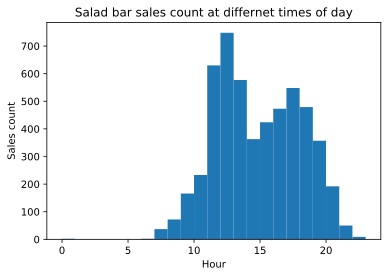

In [53]:
transactions_demographic[transactions_demographic.DEPARTMENT == "SALAD BAR"]["HOUR"].plot.hist(bins=range(24))
plt.title("Salad bar sales count at differnet times of day")
plt.ylabel("Sales count")
plt.xlabel("Hour")
plt.show()

As we can see the salad bar has a big spike at around 1pm which suggests lots of clients buy salads for lunch, the later increase around 5pm is likely caused by clients buying salads after work or during their normal shopping (overall sales also peak at ~5pm) for example for the next day.

## Long term correlations

We wanted to see if sales of some products correlate with others. We have plotted sales in different categories and normalized them to see the correlations more easily.

(Some categories have very little sales over all, so even if they would correlate with other it would be hard to see that on a plot without normalizing).

In [10]:
def compare_specific_categories(data, category_column, labels, statistic_computation, sort=True, title=None):
    data = data[data[category_column].isin(labels)]
    
    values = data[category_column].unique()
    if sort:
        values = sorted(values)
    
    def summarize_category(category_name):
        filtered = data[data[category_column] == category_name]
        stat = statistic_computation(filtered)
        return stat
    
    stats = list(map(summarize_category, values))

    plt.figure(figsize=(10,8))
    for cat, stat in zip(values, stats):

        plt.plot(stat.index, stat, label=cat)
        #print(stat)
    plt.xlabel("Month")
    plt.ylabel("Relative sales in given month")
    if title is None:
        title = "Comparison over " + category_column
    plt.title(title)
    plt.legend()
    plt.show()

def stat_relative_overall_monthly_quantity(data):
    overall = data["QUANTITY"].sum()
    return (data.groupby("MONTH")["QUANTITY"].sum() / overall)

def stat_relative_minmax_overall_monthly_quantity(data):
    monthly = data.groupby("MONTH")["QUANTITY"].sum()
    mini = monthly.min()
    maxi = monthly.max()
    return (monthly - mini) / (maxi - mini)

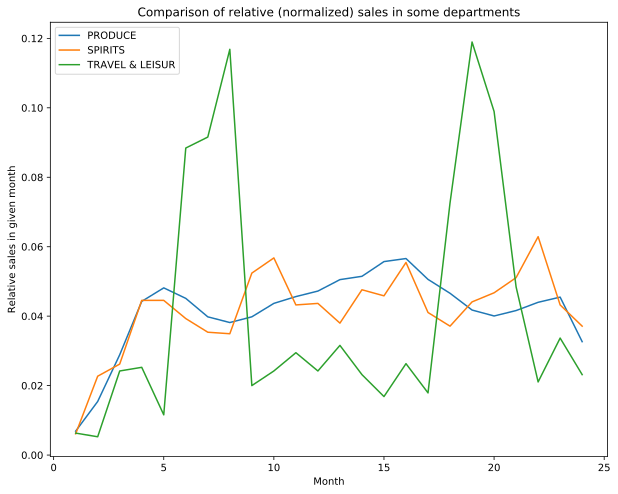

In [16]:
compare_specific_categories(merged, "DEPARTMENT", ["TRAVEL & LEISUR", "SPIRITS", "PRODUCE"], stat_relative_overall_monthly_quantity, title="Comparison of relative (normalized) sales in some departments")

We can see that TRAVEL has cyclical spikes in months 6-8 (which coincides with summer) likely due to people going on vacation.

At the same time there is a light drop in SPIRITS and PRODUCE sales (PRODUCE is mostly daily food products). This can likely be explained by the fact that people going on vacation often don't do the regular shopping (for example because they are more likely to dine in a restaurant rather than cook) and go abroad (so their shopping is not counted in the dataset we have).